# Proximal Policy Optimisation

Proximal Policy Optimisation (PPO) is a well-regarded policy-gradient algorithm for reinforcement learning. It directly learns the action policy, making it suitable for continuous, multidimensional actions with potentially complex loss landscapes, as the CityLearn environment does. It is also a good starting point because it is relatively easy to tune. The core characteristic of PPO amongst other policy-gradient methods is that learning is made stable by preventing policy changes that are too large: the KL divergence is calculated between the existing policy and an updated one, and the new policy is simply clipped to prevent it diverging too far from the existing policy.

This notebook shows training, evaluation and hyperparameter tuning of the PPO algorithm, with comparisons to the random-action and constant-action baseline agents explored in the "EDA and baselines" notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

In [2]:
# Initialise CityLearn environment
DATASET_NAME = 'citylearn_challenge_2022_phase_1'
schema = DataSet.get_schema(DATASET_NAME)

def initialise_env(schema):
    
    env = CityLearnEnv(schema, central_agent=True)

    # Wrappers to make the environment compatible with Stable Baselines 3
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    
    return env

env = initialise_env(schema)

In [3]:
# Create a logger for tracking Stable Baselines 3 models with MLFlow (code from Stable Baselines 3 documentation)
import sys
from typing import Any, Dict, Tuple, Union

import mlflow
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger
from stable_baselines3.common.evaluation import evaluate_policy

from datetime import datetime


class MLflowOutputFormat(KVWriter):
    """
    Dumps key/value pairs into MLflow's numeric format.
    """

    def write(
        self,
        key_values: Dict[str, Any],
        key_excluded: Dict[str, Union[str, Tuple[str, ...]]],
        step: int = 0,
    ) -> None:

        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())
        ):

            if excluded is not None and "mlflow" in excluded:
                continue

            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    mlflow.log_metric(key, value, step)


loggers = Logger(
    folder=None,
    output_formats=[HumanOutputFormat(sys.stdout), MLflowOutputFormat()],
)

# Training a PPO model with default hyperparameters

In [4]:
# Train a PPO model (this will be an additional baseline)
def train_and_log_ppo(env, ppo_params=None, n_epochs=10, n_eval_eps=5, n_steps=2184, eval_freq=1):

    print(f"{datetime.now()} - Starting MLflow run")

    with mlflow.start_run():

        print(f"{datetime.now()} - MLflow run started")

        # Instantiate PPO agent, using non-default model parameters if specified
        params = {"policy": "MlpPolicy", "verbose": 0}
        if ppo_params:
            params.update(ppo_params)
        model = PPO(**params, env=env)
        model.set_logger(loggers)

        for epoch in range(n_epochs):

            print(f"{datetime.now()} - Epoch {epoch} of {n_epochs - 1} started")

            # Train the model for n_steps
            model.learn(total_timesteps=n_steps, reset_num_timesteps=False)

            # Log model after each 'epoch' of training
            if epoch % eval_freq == 0:

                # Evaluate the model
                mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_eps)

                # Log metrics to MLflow
                mlflow.log_metric("eval_mean_reward", mean_reward, step=epoch)

                print(f"{datetime.now()} - Epoch {epoch} evaluation done; logging metrics")


In [5]:
%%time

# Train for 10 epochs, using default hyperparameter values
train_and_log_ppo(env)

2023-09-29 05:59:43.422950 - Starting MLflow run
2023-09-29 05:59:44.640641 - MLflow run started
2023-09-29 06:00:07.882362 - Epoch 0 of 9 started
-----------------------------
| time/              |      |
|    fps             | 80   |
|    iterations      | 1    |
|    time_elapsed    | 25   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 2           |
|    time_elapsed         | 52          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006265227 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | 0.00633     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.17e+03    |
|    n_updates            | 10          |
|    policy_g

/usr/local/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


2023-09-29 06:07:05.685558 - Epoch 0 evaluation done; logging metrics
2023-09-29 06:07:05.703665 - Epoch 1 of 9 started
------------------------------------------
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 1            |
|    time_elapsed         | 17           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0065443646 |
|    clip_fraction        | 0.048        |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | -0.000482    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.38e+03     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00843     |
|    std                  | 1            |
|    value_loss           | 5.16e+03     |
------------------------------------------
------------------------------------------
| time/             

2023-09-29 06:35:19.908478 - Epoch 5 evaluation done; logging metrics
2023-09-29 06:35:19.932257 - Epoch 6 of 9 started
----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 1          |
|    time_elapsed         | 21         |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.00791553 |
|    clip_fraction        | 0.0619     |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.92      |
|    explained_variance   | 4.95e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 1.64e+03   |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.00969   |
|    std                  | 0.962      |
|    value_loss           | 3.46e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps         

In [6]:
# Run MLFlow UI
!mlflow ui --host 0.0.0.0

# (Now navigate to http://localhost:5000 in web browser)

[2023-09-29 07:49:59 +0000] [225] [INFO] Starting gunicorn 20.1.0
[2023-09-29 07:49:59 +0000] [225] [INFO] Listening at: http://0.0.0.0:5000 (225)
[2023-09-29 07:49:59 +0000] [225] [INFO] Using worker: sync
[2023-09-29 07:49:59 +0000] [228] [INFO] Booting worker with pid: 228
^C
[2023-09-29 10:38:02 +0000] [225] [INFO] Handling signal: int


## Examining the metrics

First, the mean evaluation reward.
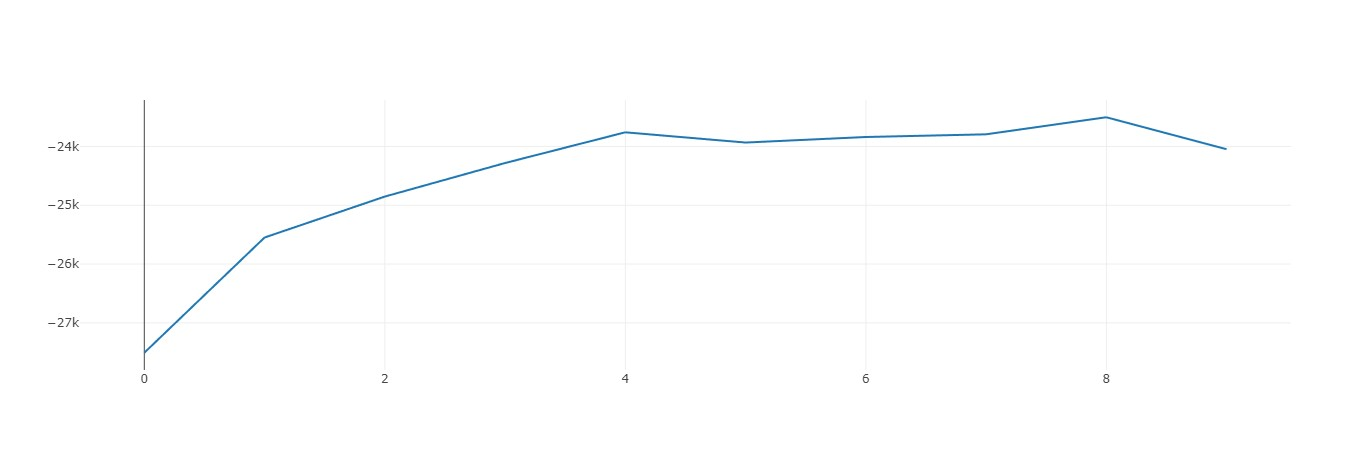
This shows an upward trend over the first 4 or 5 training/evaluation cycles, but plateaus  at the low mean reward of around -24k, comparable to the baseline agent taking constant actions of 0. This means the agent has ultimately not learned a good policy for the task. There are many possible explanations for this: not enough training time; poorly tuned hyperparameters causing the agent to get stuck in a local minimum; or an inappropriate model, for example not complex enough to handle the complex loss landscape. Examining the training losses will give more insight.

Second, the total loss.
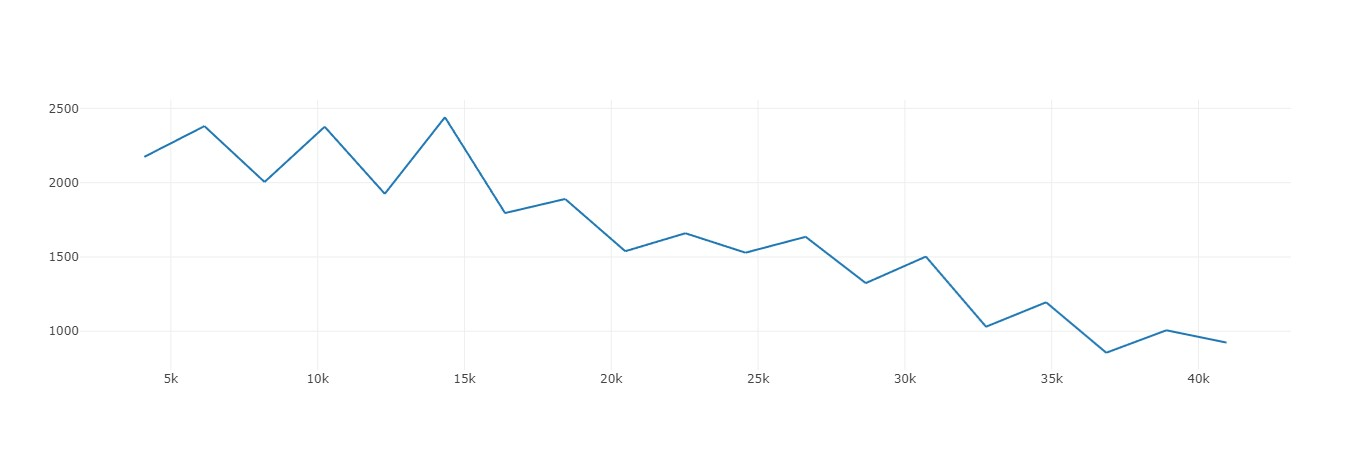
The total loss for the PPO algorithm is a combination of the policy gradient loss (which penalises suboptimal actions), the value loss (which minimises the error between estimated state value and observed return), and an entropy bonus. The plot shows a reasonably stable decrease over the whole training period, which suggests that more training time would have helped the model improve further. Looking at each individual loss will explain the learning patterns further and pull apart how the model is behaving.

Third, the policy gradient loss.
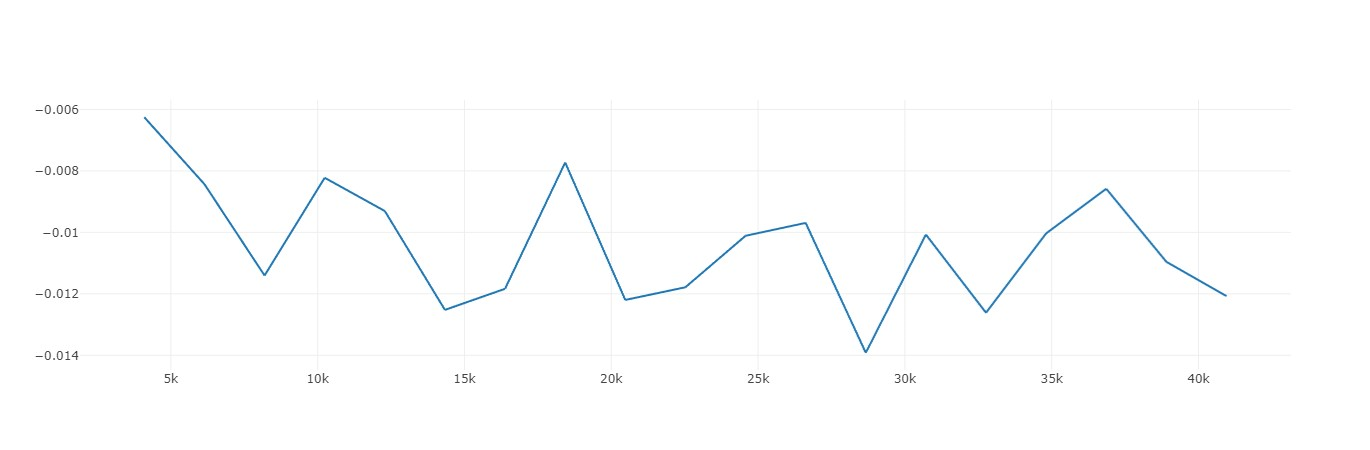
This does not show any sigificant trends (either increasing, decreasing, converging or diverging), which suggests that the policy itself of choosing better actions than average in a given state is not improving. This could be because it is stuck in a local minimum, or because the environment is so complex that it has not yet found a consistent direction of consistent improvement. It is not clear whether further training time would help with this, but tuning the hyperparameters probably would.

Fourth, the value loss.
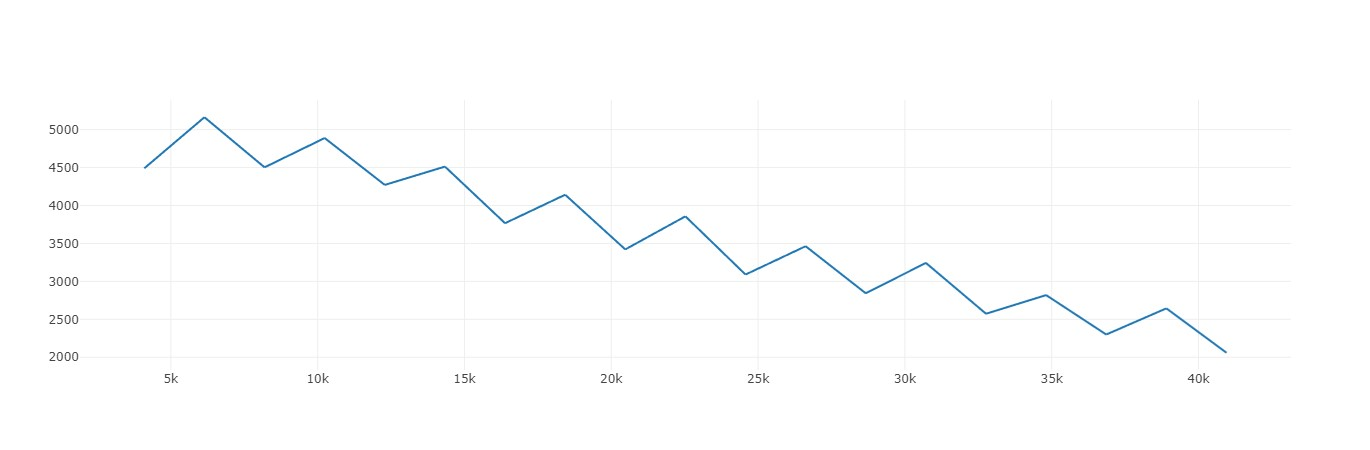
This shows a steady downward trend which shows that the critic is learning to predict future returns.

Fifth, the entropy loss.
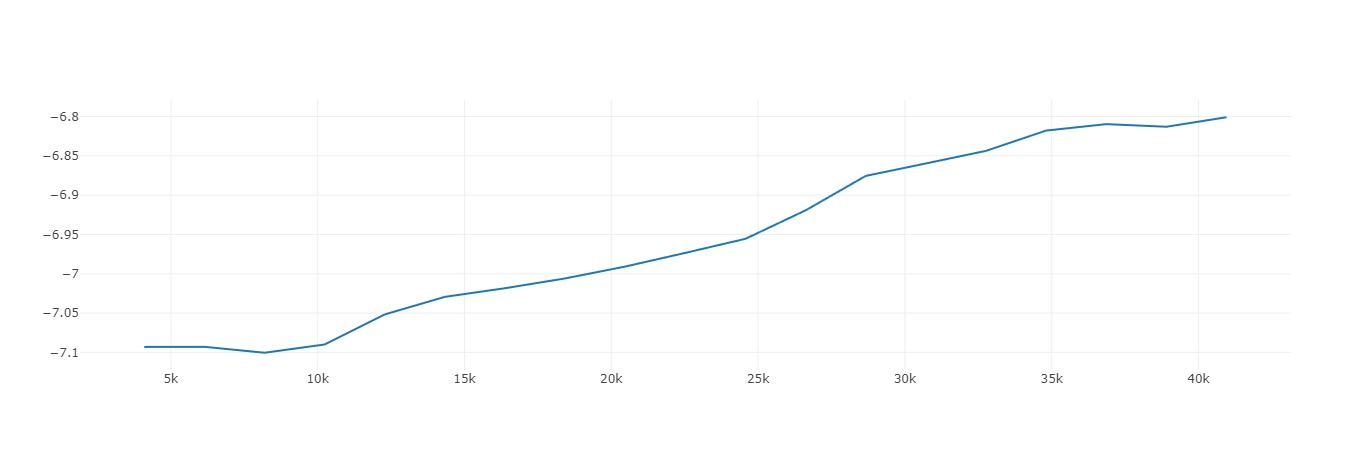
This shows a steady increase, in contrast to the usual expected behaviour of a gradual decrease in entropy. This suggests that the actor is not stuck in a local minimum, but unable to find a direction of consistent improvement and is therefore increasing the randomness of its actions.

Training for longer might help, but tuning the hyperparameters first could speed up the protoyping process.

# Optimising PPO parameters with Optuna

Optuna is a library for hyperparameter tuning, which uses effective techniques including Bayesian sampling of hyperparameters and early stopping of poorly-performing trials to make tuning more efficient.

For the first step, the learning rate, n_steps and clip rate are tuned, training for the same number of steps as above (3 months). Limiting it to just three of the most important hyperparameters makes the problem simpler and therefore more likely to improve on the default PPO performanace; other hyperparameters can be tuned later.

This experiment is run for a maximum of 100 trials or 12 hours of wall time, evaluating performance 4 times during training to give an indication of the stability of learning, and "pruning" (i.e. stopping early) the worse-performing half of trials after the second evaluation to save some time and concentrate resources on the best-performing half.

In [5]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from stable_baselines3.common.callbacks import EvalCallback

In [6]:
# Hyperparameter tuning parameters
N_EVALUATIONS = 4             # For monitoring: how many times during training to evaluate the agent
N_EVAL_EPISODES = 3           # Number of episodes to evaluate and take average reward over
N_TRIALS = 100                # Number of trials (hyperparameter combinations)
N_STARTUP_TRIALS = 5          # Number of trials to try before early stopping / pruning
N_WARMUP_STEPS = 2            # Number of steps to evaluate before early stopping / pruning
N_TIMESTEPS = 2184
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
TIMEOUT = int(12 * 60 * 60)   # Timeout in seconds 

In [7]:
# Callback function to report trials to Optuna during training
class TrialEvalCallback(EvalCallback):

    def __init__(
        self,
        eval_env: StableBaselines3Wrapper,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


In [9]:
# Objective function: return the highest mean reward
def objective(trial):
    
    # Initialise environment
    env = initialise_env(schema)
    
    # Define hyperparameter ranges
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)  # 0.0001 to 0.001; default 0.0003
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 4, 11)                 # 16 to 2048; default 2048
    #batch_size = 2 ** trial.suggest_int("exponent_batch_size", 4, 10)           # 16 to 256; default 64
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)                    # 0.1 to 0.3; default 0.2
    #gamma = 1.0 - trial.suggest_float("gamma", 0.001, 0.05, log=True)           # 0.95 to 0.999; default 0.95
    #gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.01, 0.1, log=True)   # 0.9 to 0.99; default 0.95
    #ent_coef = trial.suggest_float("ent_coef", 0.0, 0.1)                        # 0 to 0.1; default 0.0
  
    # Initialise PPO model with sampled hyperparameters
    model = PPO('MlpPolicy',
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                #batch_size=batch_size,
                clip_range=clip_range,
                #gamma=gamma,
                #gae_lambda=gae_lambda,
                #ent_coef=ent_coef,
                verbose=0)
    
    # Create callback for evaluating and reporting performance
    eval_callback = TrialEvalCallback(env,
                                      trial,
                                      n_eval_episodes=N_EVAL_EPISODES,
                                      eval_freq=EVAL_FREQ,
                                      deterministic=True)
    
    # Train model
    model.learn(total_timesteps=N_TIMESTEPS, callback=eval_callback)
  
    # Evaluate model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=N_EVAL_EPISODES)
  
    return mean_reward

In [ ]:
%%time

# Specify Bayesian kernel-fitting-based sampler and median pruner for tuning
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS, seed=110)
pruner = MedianPruner(
    n_startup_trials = N_STARTUP_TRIALS,
    n_warmup_steps = N_WARMUP_STEPS)

# Run Optuna study
study = optuna.create_study(direction='maximize',
                            sampler=sampler,
                            pruner=pruner,
                            study_name="PPO")
study.optimize(objective,
               n_trials=N_TRIALS,
               timeout=TIMEOUT)

# Print results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-10-04 22:27:42,129] A new study created in memory with name: PPO
/usr/local/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,
[I 2023-10-04 22:43:50,223] Trial 0 finished with value: -27361.8726875321 and parameters: {'learning_rate': 0.0001306347932609768, 'exponent_n_steps': 9, 'clip_range': 0.17511779659330878}. Best is trial 0 with value: -27361.8726875321.
[I 2023-10-04 22:59:04,114] Trial 1 finished with value: -27228.588044473116 and parameters: {'learning_rate': 0.0004099987961702125, 'exponent_n_steps': 9, 'clip_range': 0.23649262584451797}. Best is trial 1 with value: -27228.588044473116.
[I 2023-10-04 23:14:30,880] Trial 2 finished with value: -26012.77908521006 and parameters: {'learni

[I 2023-10-05 06:24:40,865] Trial 29 finished with value: -26485.462470389903 and parameters: {'learning_rate': 0.0008830705073869338, 'exponent_n_steps': 8, 'clip_range': 0.1806343634798507}. Best is trial 21 with value: -25810.062371748965.
[I 2023-10-05 06:39:32,279] Trial 30 finished with value: -24997.349297887384 and parameters: {'learning_rate': 0.0007417398065290696, 'exponent_n_steps': 9, 'clip_range': 0.2533686868950648}. Best is trial 30 with value: -24997.349297887384.
[I 2023-10-05 06:51:22,533] Trial 31 finished with value: -27588.650887201075 and parameters: {'learning_rate': 0.0007380982581203728, 'exponent_n_steps': 9, 'clip_range': 0.25652580997987556}. Best is trial 30 with value: -24997.349297887384.
[I 2023-10-05 07:03:11,526] Trial 32 finished with value: -27902.3855082104 and parameters: {'learning_rate': 0.00046025729925661774, 'exponent_n_steps': 9, 'clip_range': 0.22637132261551132}. Best is trial 30 with value: -24997.349297887384.
[I 2023-10-05 07:15:50,028]

In [88]:
# Save hyperparameter tuning results
study.trials_dataframe().to_csv("ppo_tuning_results_v0.csv")

## Examining the hyperparameter tuning

In [100]:
from optuna.visualization import plot_optimization_history, plot_intermediate_values, plot_param_importances, plot_slice, plot_parallel_coordinate

fig1 = plot_optimization_history(study)
fig2 = plot_intermediate_values(study)
fig3 = plot_param_importances(study)
fig4 = visualization.plot_slice(study);
fig5 = plot_parallel_coordinate(study);
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

The Optimization History Plot shows that most combinations of hyperparameters produced a return of around -27.5k, with quite a lot of worse performers and a handful of better performers.

The Intermediate Values Plot shows why some of them were performing so badly: with more steps (more learning), many of them got worse: see trial 11, the worst-performing trial, which quickly plateaued at a very low value. The best-performing trial, trial 103, shows the highest return at the end of evaluation, but it is notable that the return on previous steps was lower; this could indicate unstable learning dynamics which makes the model too unreliable to use. Evaluating its metrics further will illuminate this.

The Hyperparameter Importances plot gives an insight into what matters for performance. Performance was most sensitive to the learning rate, so if there is a need to manually tune the hyperparameters a little further later, the learning rate is a good place to start.

Ultimately, this broad initial hyperparameter tuning did not yield better results than the default hyperparameters, so a more refined approach is needed. One possibility is simply that more training time is needed: for that reason, the default PPO is trained again for 30 epochs, instead of 10, to see whether the reward increases and the policy gradient loss stabilises given more training.

# Training for longer

In [6]:
# Train for 30 epochs, using default hyperparameter values
train_and_log_ppo(env, n_epochs=30)

2023-10-05 12:42:55.351144 - Starting MLflow run
2023-10-05 12:42:56.756648 - MLflow run started
2023-10-05 12:43:29.368504 - Epoch 0 of 29 started
-----------------------------
| time/              |      |
|    fps             | 37   |
|    iterations      | 1    |
|    time_elapsed    | 54   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 50           |
|    iterations           | 2            |
|    time_elapsed         | 80           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0065766564 |
|    clip_fraction        | 0.0426       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.1         |
|    explained_variance   | -0.00139     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.98e+03     |
|    n_updates            | 10          

/usr/local/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:71: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


2023-10-05 12:49:47.520760 - Epoch 0 evaluation done; logging metrics
2023-10-05 12:49:47.520997 - Epoch 1 of 29 started
-----------------------------------------
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 1           |
|    time_elapsed         | 17          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.009632624 |
|    clip_fraction        | 0.0978      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | 0.000136    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.6e+03     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0131     |
|    std                  | 0.995       |
|    value_loss           | 5.24e+03    |
-----------------------------------------
------------------------------------------
| time/                   |           

2023-10-05 13:17:40.280858 - Epoch 5 evaluation done; logging metrics
2023-10-05 13:17:40.281064 - Epoch 6 of 29 started
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.006262677 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.78       |
|    explained_variance   | 6.14e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.4e+03     |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00936    |
|    std                  | 0.937       |
|    value_loss           | 3.42e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |            

2023-10-05 13:45:21.240589 - Epoch 10 evaluation done; logging metrics
2023-10-05 13:45:21.240764 - Epoch 11 of 29 started
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 1            |
|    time_elapsed         | 17           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0074150586 |
|    clip_fraction        | 0.0667       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.4         |
|    explained_variance   | 1.85e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 803          |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00979     |
|    std                  | 0.868        |
|    value_loss           | 1.95e+03     |
------------------------------------------
----------------------------------------
| time/            

2023-10-05 14:13:50.247973 - Epoch 15 evaluation done; logging metrics
2023-10-05 14:13:50.248168 - Epoch 16 of 29 started
-----------------------------------------
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 1           |
|    time_elapsed         | 25          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.010220917 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.1        |
|    explained_variance   | 4.17e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 489         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.821       |
|    value_loss           | 1.14e+03    |
-----------------------------------------
------------------------------------------
| time/                   |         

2023-10-05 14:44:37.739851 - Epoch 20 evaluation done; logging metrics
2023-10-05 14:44:37.740386 - Epoch 21 of 29 started
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 1           |
|    time_elapsed         | 19          |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.010921365 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.83       |
|    explained_variance   | 2.98e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 278         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 0.776       |
|    value_loss           | 613         |
-----------------------------------------
-----------------------------------------
| time/                   |          

2023-10-05 15:14:03.256657 - Epoch 25 evaluation done; logging metrics
2023-10-05 15:14:03.256870 - Epoch 26 of 29 started
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 1           |
|    time_elapsed         | 17          |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.019116685 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.54       |
|    explained_variance   | 2.38e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 211         |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00336    |
|    std                  | 0.732       |
|    value_loss           | 447         |
-----------------------------------------
-----------------------------------------
| time/                   |          

Mean evaluation reward
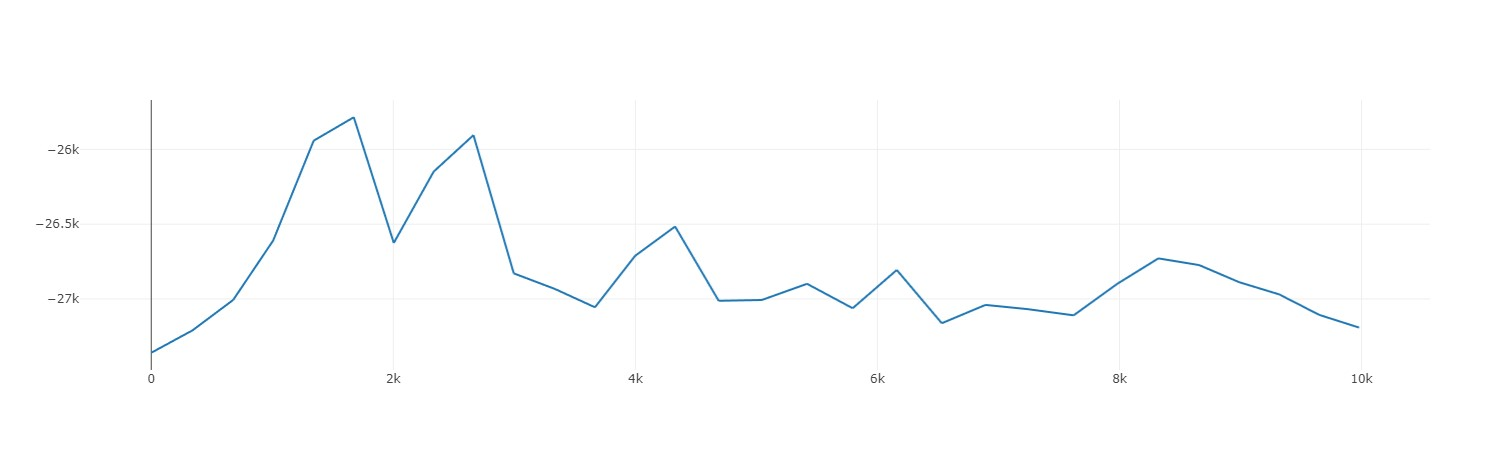

Total loss
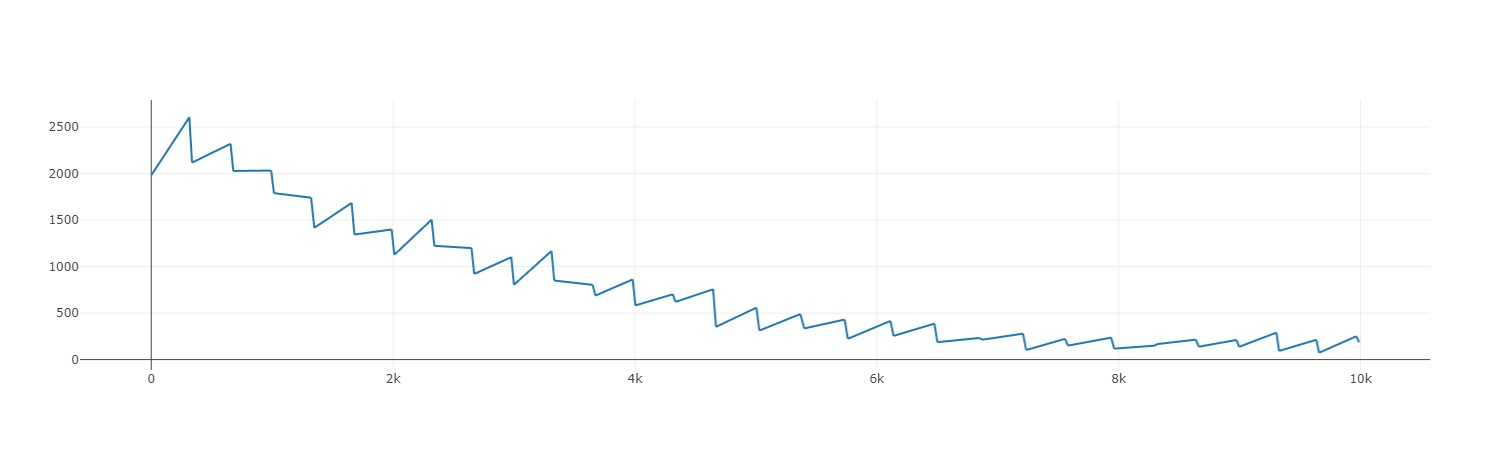

Policy gradient loss
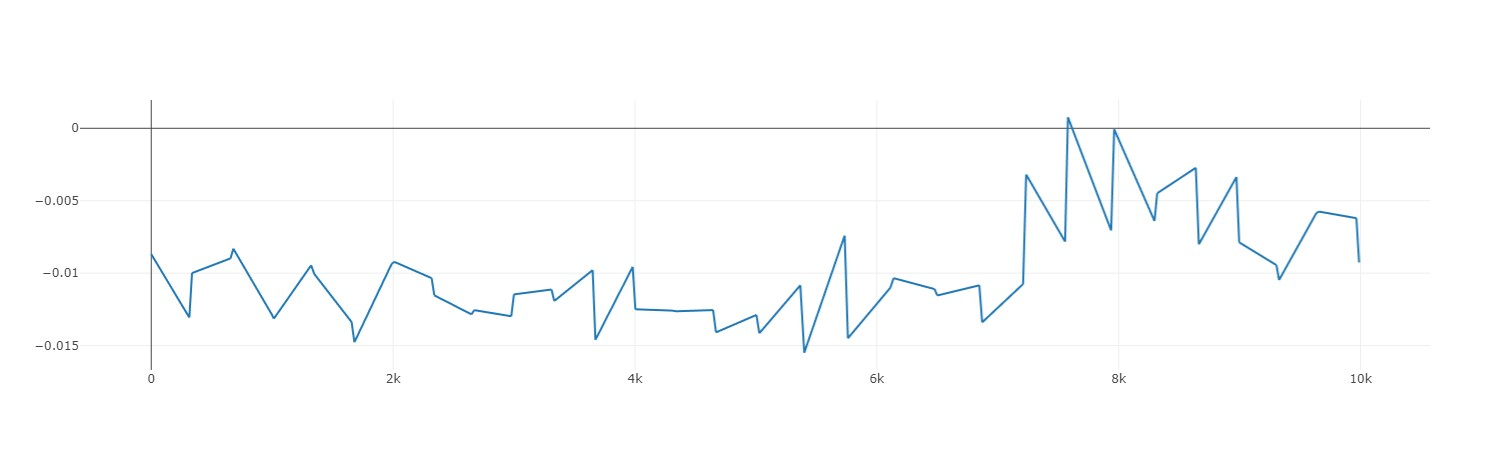

Value loss
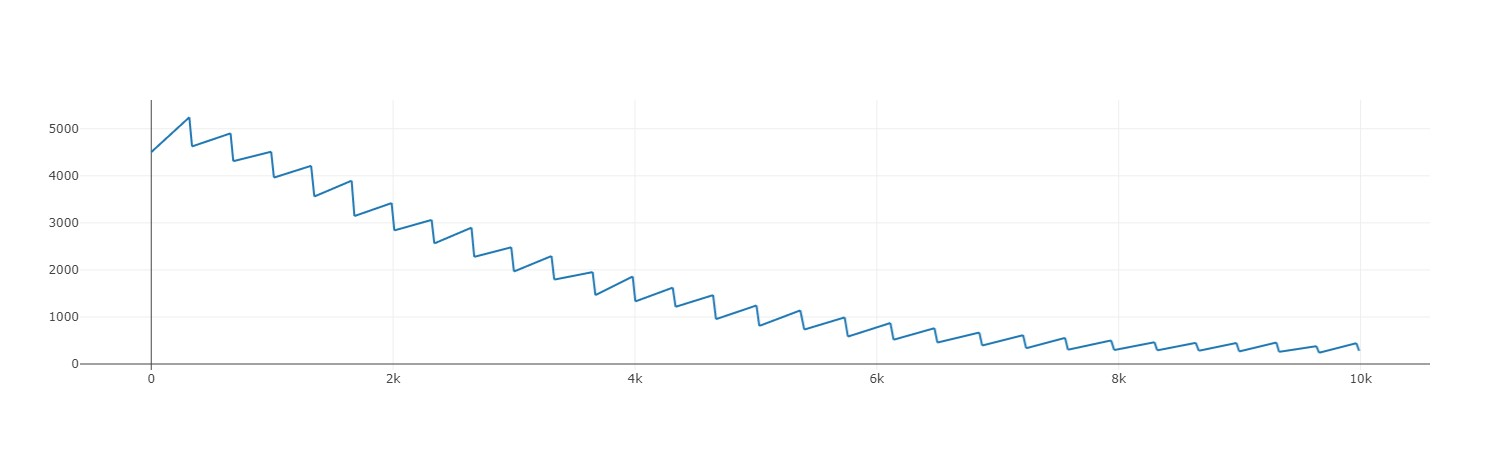

Entropy loss
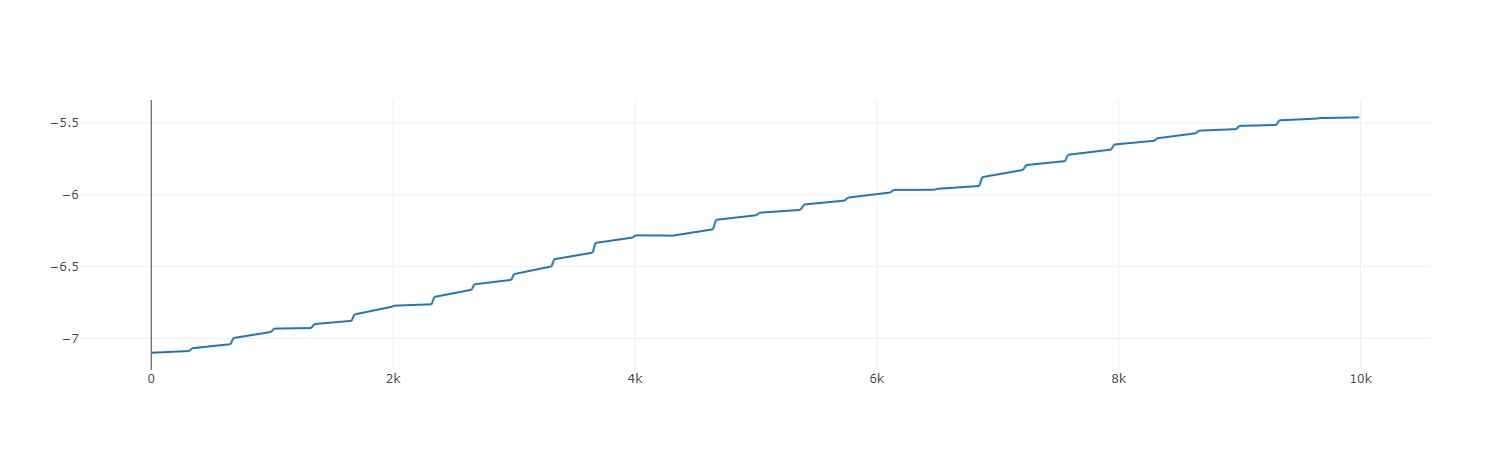

The loss patterns are still much as they were, except that the policy gradient loss gets even more erratic and the reward decreases. Setting the clip range lower may mitigate this and stabilise the policy updates.